# Feature hacking

In this recitation, we will see another example of feature hacking and cross validation using LASSO glm. 

## Goal of the lab

* Learn about the difference between parameter tuning and feature hacking
* Learn how to use the cv.glmnet function
* Learn to use held out test set to evaluation model performance

As we discussed in class, feature hacking, a model training technique that leads to overfitting, can be used in the feature selection process. In class, we have seen an example of this in the context of LASSO regression. In this recitation, we will use another similar example in the context of classification using glm LASSO.

To begin with, we will use the dataset Hitters in the ISLR package. 

In [1]:
library(ISLR)
library(tidyverse)
library(glmnet)
names(Hitters)
length(names(Hitters))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 3.0-2




[1] "AtBat"     "Hits"      "HmRun"     "Runs"      "RBI"       "Walks"    
 [7] "Years"     "CAtBat"    "CHits"     "CHmRun"    "CRuns"     "CRBI"     
[13] "CWalks"    "League"    "Division"  "PutOuts"   "Assists"   "Errors"   
[19] "Salary"    "NewLeague"

[1] 20

Make sure we clean all the NA values in the dataset and remove the "League" variable in the dataset.

In [2]:
Hitters %>%
    na.omit(Hitters) -> Hitters1
    #select(-c(NewLeague)) 
    

Now we want to use all the continuous features to predict the league that the players are in at the beginning of 1987, which is the "New League" variable. We start with our tuning set using our cross validation method with a held-out test set. 

In [3]:
# So, let's select x and y 
# Define x without the first column
X = model.matrix(Division~., Hitters1)[,-1]#without first intercept column
colnames(X)
#the model.matrix function also automatically transforms qualitative variables
#into dummy variables
Y = Hitters1$Division #selecting y from the dataframe
print(length(Y))
###Next we will select our tuning dataset as well, which is a randomly selected 200 data points
tune_idx <- sample(nrow(X), 200)
tune_X <- X[tune_idx, ]
tune_Y <- Y[tune_idx]
test_X <- X[-tune_idx, ]
print(dim(test_X))
test_Y <- Y[-tune_idx]

[1] "AtBat"      "Hits"       "HmRun"      "Runs"       "RBI"       
 [6] "Walks"      "Years"      "CAtBat"     "CHits"      "CHmRun"    
[11] "CRuns"      "CRBI"       "CWalks"     "LeagueN"    "PutOuts"   
[16] "Assists"    "Errors"     "Salary"     "NewLeagueN"

[1] 263
[1] 63 19


[1] 0.06095796


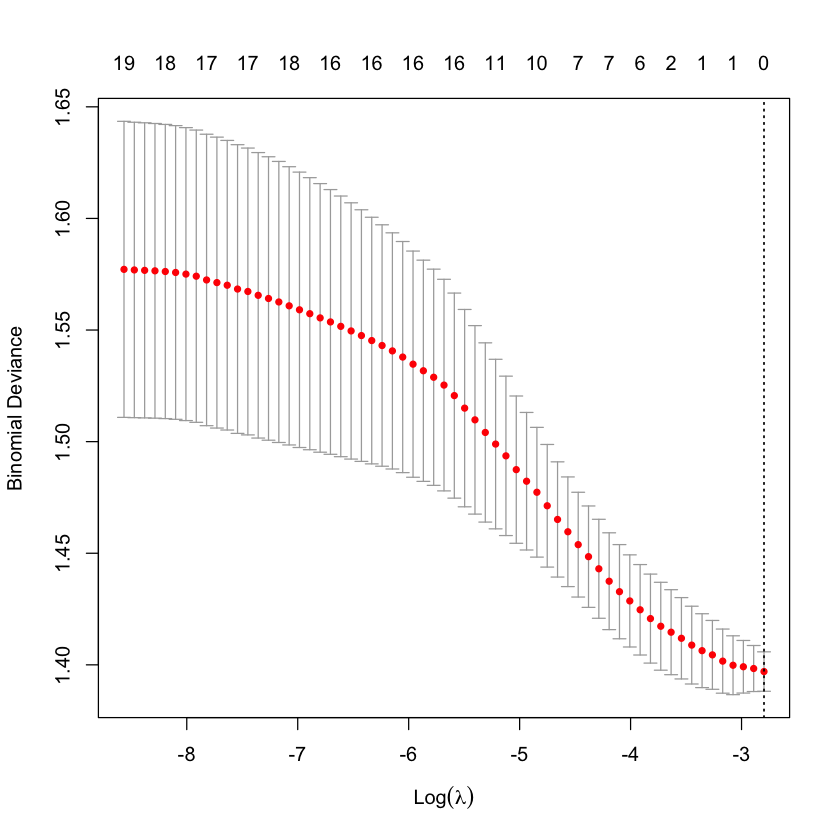

In [4]:
set.seed(2)
tuned_model <- cv.glmnet(tune_X, tune_Y, family = 'binomial', alpha = 1)
plot(tuned_model)
lambda_tuned <- tuned_model$lambda.min
##This would be the best tuned lambda value to use for the model
print(lambda_tuned)

Let's see how our tuned model does with the held-out test set:

In [5]:
tuned_pred <- data.frame(predict(tuned_model, test_X, type = 'response'))
###change to column to prob to suggest predicted probability
colnames(tuned_pred) <- 'prob'
tuned_pred$response <- rep('W', nrow(test_X))
tuned_pred$response[tuned_pred$prob<0.5] <- 'E'

tuned_acc <- mean(tuned_pred$response == test_Y)
print(tuned_acc)

[1] 0.4285714


Now let's see what happens when we use feature hackng to create a hacked model. That is, when we train the model with the full dataset without using a held out test set. 

[1] 0.03795896


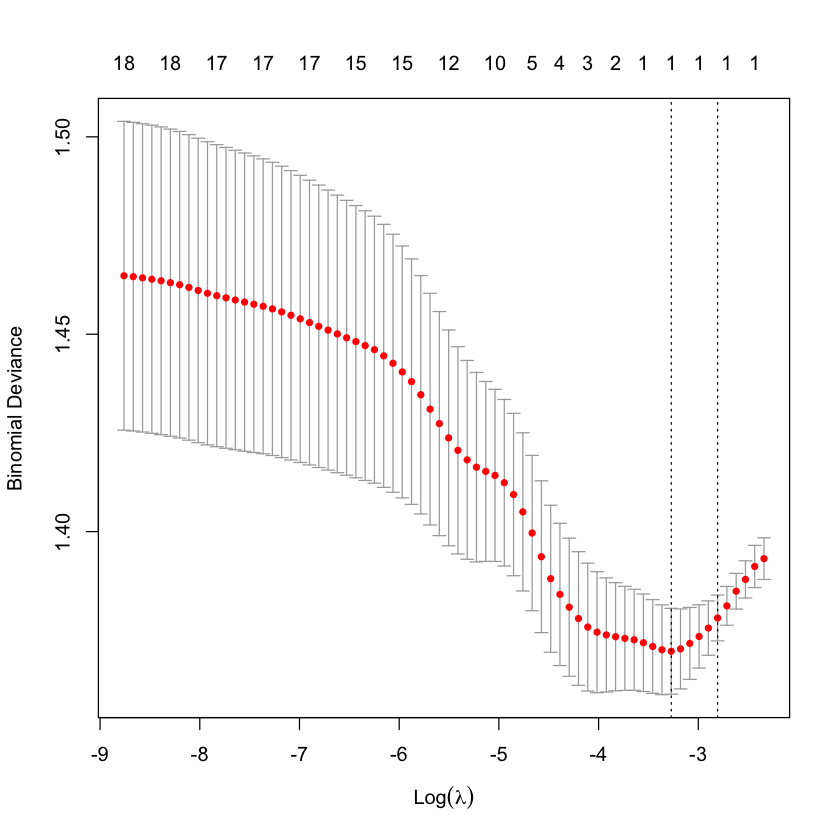

In [6]:
set.seed(2)
hacked_model <- cv.glmnet(X, Y, family = 'binomial', alpha = 1)
plot(hacked_model)
lambda_hacked <- hacked_model$lambda.min
print(lambda_hacked)

Now let's see how this hacked model does with the test accuracy. The expectation is 

In [7]:
hacked_pred <- data.frame(predict(hacked_model, test_X, type = 'response'))
###change to column to prob to suggest predicted probability
colnames(hacked_pred) <- 'prob'
hacked_pred$response <- rep('W', nrow(test_X))
hacked_pred$response[hacked_pred$prob<0.5] <- 'E'
hacked_acc <- mean(hacked_pred$response == test_Y)
print(hacked_acc)

[1] 0.6666667


In [8]:
tuned <- glmnet(tune_X, tune_Y, family = 'binomial', alpha = 1, lambda = lambda_tuned)
hacked <- glmnet(X, Y, family = 'binomial', alpha = 1, lambda = lambda_hacked)
print(tuned$beta)
print(hacked$beta)

19 x 1 sparse Matrix of class "dgCMatrix"
           s0
AtBat       0
Hits        .
HmRun       .
Runs        .
RBI         .
Walks       .
Years       .
CAtBat      .
CHits       .
CHmRun      .
CRuns       .
CRBI        .
CWalks      .
LeagueN     .
PutOuts     .
Assists     .
Errors      .
Salary      .
NewLeagueN  .
19 x 1 sparse Matrix of class "dgCMatrix"
                      s0
AtBat       .           
Hits        .           
HmRun       .           
Runs        .           
RBI         .           
Walks       .           
Years       .           
CAtBat      .           
CHits       .           
CHmRun      .           
CRuns       .           
CRBI        .           
CWalks      .           
LeagueN     .           
PutOuts     .           
Assists     .           
Errors      .           
Salary     -0.0005303816
NewLeagueN  .           


In [9]:
n_hacked_params = sum(coef(hacked)!=0) 
n_tune_params = sum(coef(tuned)!=0)
print(n_hacked_params)
print(n_tune_params)

[1] 2
[1] 1


In [12]:
n_iterations = 10000
acc = matrix(0,nrow=n_iterations,ncol=1)
for (i in 1:n_iterations){
    p2use = sample(1:18)[1:n_hacked_params]
    new_X = test_X[,p2use]
    glm.fit = glm(test_Y~new_X, family="binomial")
    glm.pred = data.frame(predict(glm.fit, type = 'response'))
    glm.response = rep('W', nrow(test_X))
    glm.response[glm.pred < 0.5] <- 'E'
    acc[i] = mean(glm.response == test_Y)
 }

#print(acc)

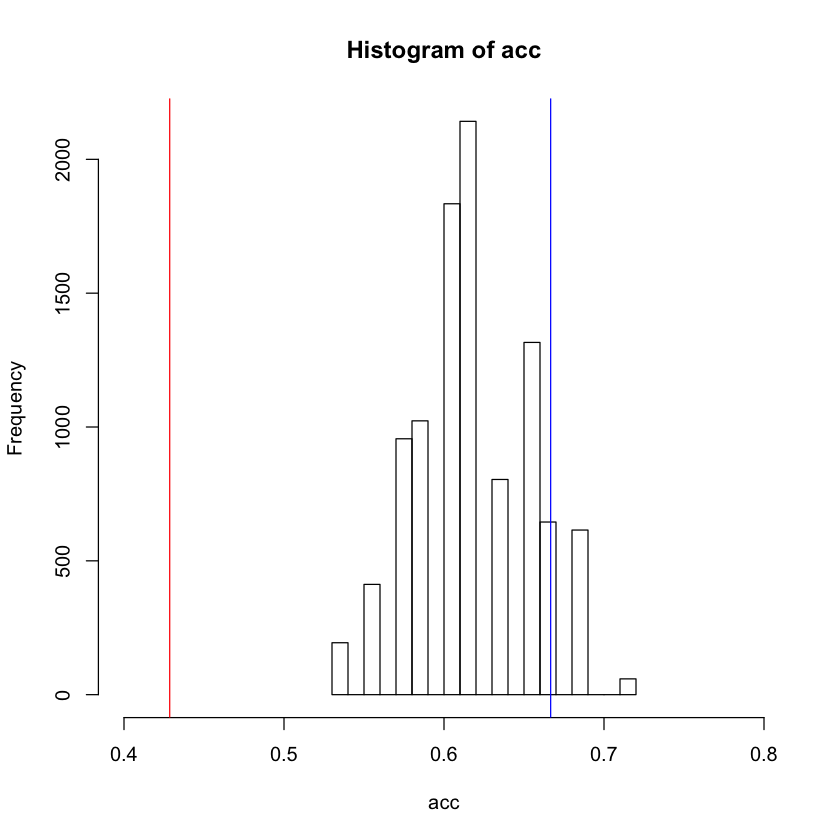

In [13]:
hist(acc, xlim = c(0.4, 0.8))
abline(v=tuned_acc, col="red")
abline(v=hacked_acc, col="blue")